# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
res = (-1)*(0.8*np.log(0.8)+0.2*np.log(0.2))
res.round(2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
h_rl = 1 * 0  # в листе с идеальным разбиением
h_rr = 1 * 0
h_r = 2 * (0.8 * 0.2)

res = h_r - 0.8 * h_rl - 0.2 * h_rr
round(res,2)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
X = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
X.mean() # такой будет прогноз для всех объектов

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def HR_gini(y): # критерий инфомативности джини
  counts = np.bincount(y)
  p = counts/sum(counts)
  return (p*(1-p)).sum()

def HR_var(y): # критерий инфомативности дисперсия
  if(len(y) == 1) or (len(y)==0): # для случаев, когда порог слишком мал и подвыборка оказывается пустая, а так же когда разброса нет (одно число)
    res = 0
  else:
     res = y.var()
  return res

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    if feature_type == 'categorical':
        thresholds = np.unique(feature_vector)
    else:
        sorted_features = np.sort(feature_vector)
        thresholds = (sorted_features[:-1] + sorted_features[1:]) / 2  # среднее между двумя соседними

    def kek(threshold):
        if feature_type == 'categorical':
            mask = feature_vector == threshold
        else:
            mask = feature_vector <= threshold

        if task == 'classification':
            HR_l = HR_gini(target_vector[mask]) * np.sum(mask) / len(mask)
            HR_R = HR_gini(target_vector[~mask]) * np.sum(~mask) / len(mask)
        else:
            HR_l = HR_var(target_vector[mask]) * np.sum(mask) / len(mask)
            HR_R = HR_var(target_vector[~mask]) * np.sum(~mask) / len(mask)
        return HR_l + HR_R

    calc_q = np.vectorize(kek)
    q = calc_q(thresholds) # применяем функцию ко всем порогам
    q_best = q.min() # минимальный критерий ошибки
    threshold_best = min(thresholds[q == q_best]) # ищем минимальный порог (для случаев, если предикаты с разными порогами дают одинаковый критерий ошибки)
    return thresholds, q, threshold_best, q_best

In [ ]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(housing.data.shape, housing.target.shape)

(20640, 8) (20640,)


In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку MedInc.

In [ ]:
thresholds, q, threshold_best, q_best = find_best_split(feature_vector=X['MedInc'].values,
                                                               target_vector=y, task='regression', feature_type='real')

In [ ]:
print(f"Все возможные пороги: {thresholds}")
print(f"Все значения критериев ошибок (дисперсии/джини): {q}")
print(f"Лучший порог: {threshold_best}")
print(f"Самая низкая дисперсия/джини: {q_best}")

Все возможные пороги: [ 0.4999  0.4999  0.4999 ... 15.0001 15.0001 15.0001]
Все значения критериев ошибок (дисперсии/джини): [1.3314415 1.3314415 1.3314415 ... 1.3315503 1.3315503 1.3315503]
Лучший порог: 5.03515
Самая низкая дисперсия/джини: 0.9187989138801307


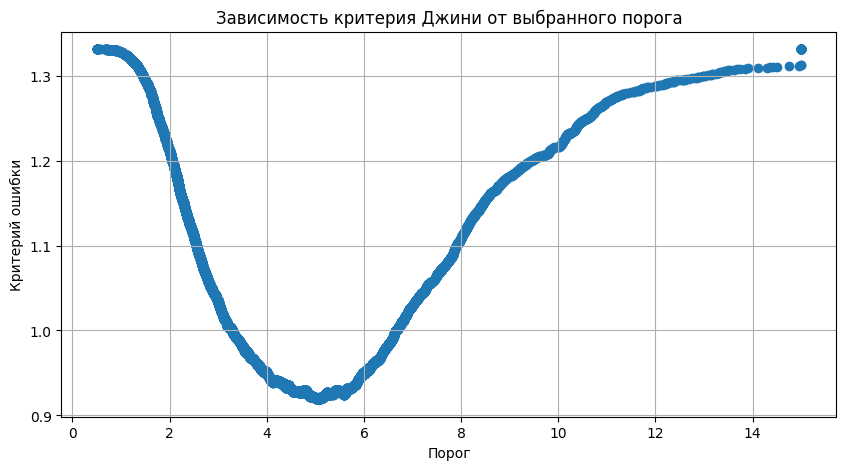

In [ ]:
plt.figure(figsize = (10,5))
plt.title('Зависимость критерия Джини от выбранного порога')
plt.scatter(thresholds,q)
plt.grid(True)
plt.xlabel('Порог')
plt.ylabel('Критерий ошибки');

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [ ]:
mydict = dict()
mydict['Parametr'] = ['Порог', 'Критерий ошибки']

for i in X.columns:
  thresholds, q, threshold_best, q_best = find_best_split(X[i].values, y, 'regression', 'real')
  mydict[i] = [threshold_best, q_best]

In [ ]:
california_houses = pd.DataFrame(mydict).set_index('Parametr')
california_houses # табличка порогов и критериев ошибки

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
Parametr,,,,,,,,
Порог,5.035150,51.000000,6.374305,1.103378,1160.00000,3.112543,37.930000,-121.870000
Критерий ошибки,0.918799,1.300649,1.172342,1.316297,1.32872,1.257632,1.241216,1.281339


In [ ]:
print(f'Минимальный критерий ошибки в столбце MedInc: {california_houses.iloc[1].min().round(4)}')

Минимальный критерий ошибки в столбце MedInc: 0.9188


При 5.035 пороге будет достигнута максимально возможная однородность в листьях при заданном условии.



---



**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [ ]:
class DecisionTree:
    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini < gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector  == threshold

                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])
    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
            return node['class']
        else:
            feature_type = self._feature_types[node['feature_split']]
            if feature_type == 'real':
                if x[node['feature_split']] < node['threshold']:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
            elif feature_type == 'categorical':
                if x[node['feature_split']] in node['category_split']:
                    return self._predict_node(x, node['left_child'])
                else:
                    return self._predict_node(x, node['right_child'])
            else:
                raise ValueError("Unknown feature type")
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
data2 = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv')
data2.drop(['Unnamed: 0'], axis = 1, inplace = True)
data2.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


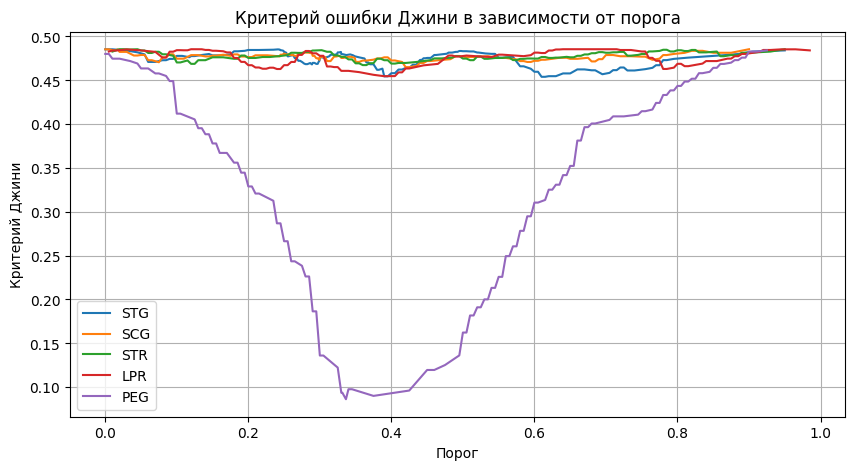

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Критерий ошибки Джини в зависимости от порога')
plt.xlabel('Порог')
plt.ylabel('Критерий Джини');
for i in data2.columns[:-1]:
    thresholds, q, threshold_best, q_best = find_best_split(data2[i].values, data2.UNS, 'classification', 'categorial')
    plt.plot(thresholds, q, label = i)
plt.legend();
plt.grid();

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Есть смысл делить выборку по признаку PEG - результаты экзамена по предмету, график критерия ошибки (Джини) принимает вид перевернутой параболы, хорошо виден минимум. По порогу, на котором достигается минимум хаотичности будем производить сплит - это у нас хороший признак.

По остальным признакам: графики ошибки еле двигаются - случаи крайне маловолатильны, какой порог ни взять - везде примерно одинаковое качество разбиения вершины... Везде ПЛОХОЕ

В общем лидер заметен сразу, по смыслу тоже все ок: мы решаем задачу классификации, где таргет UNS - уровень знаний пользователя. Можно предположить, что если человек сдал экзамен хорошо (PEG), то уровень знаний у него будет на уровне, то есть y = 1. Это наиболее значимый признак.


* STG  - кол-во времени изучения материалов по предмету тарету
* SCG - кол-во повторений материалов по предмету таргету)
* STR - кол-во учебного времени по схожим предметам)
* LPR  - экзамен. успеваемость по схожим с таргетом предметам
* PEG - экзамен. успеваемость по предмету таргету)
* UNS - уровень знаний пользователя (целевое значение)

---



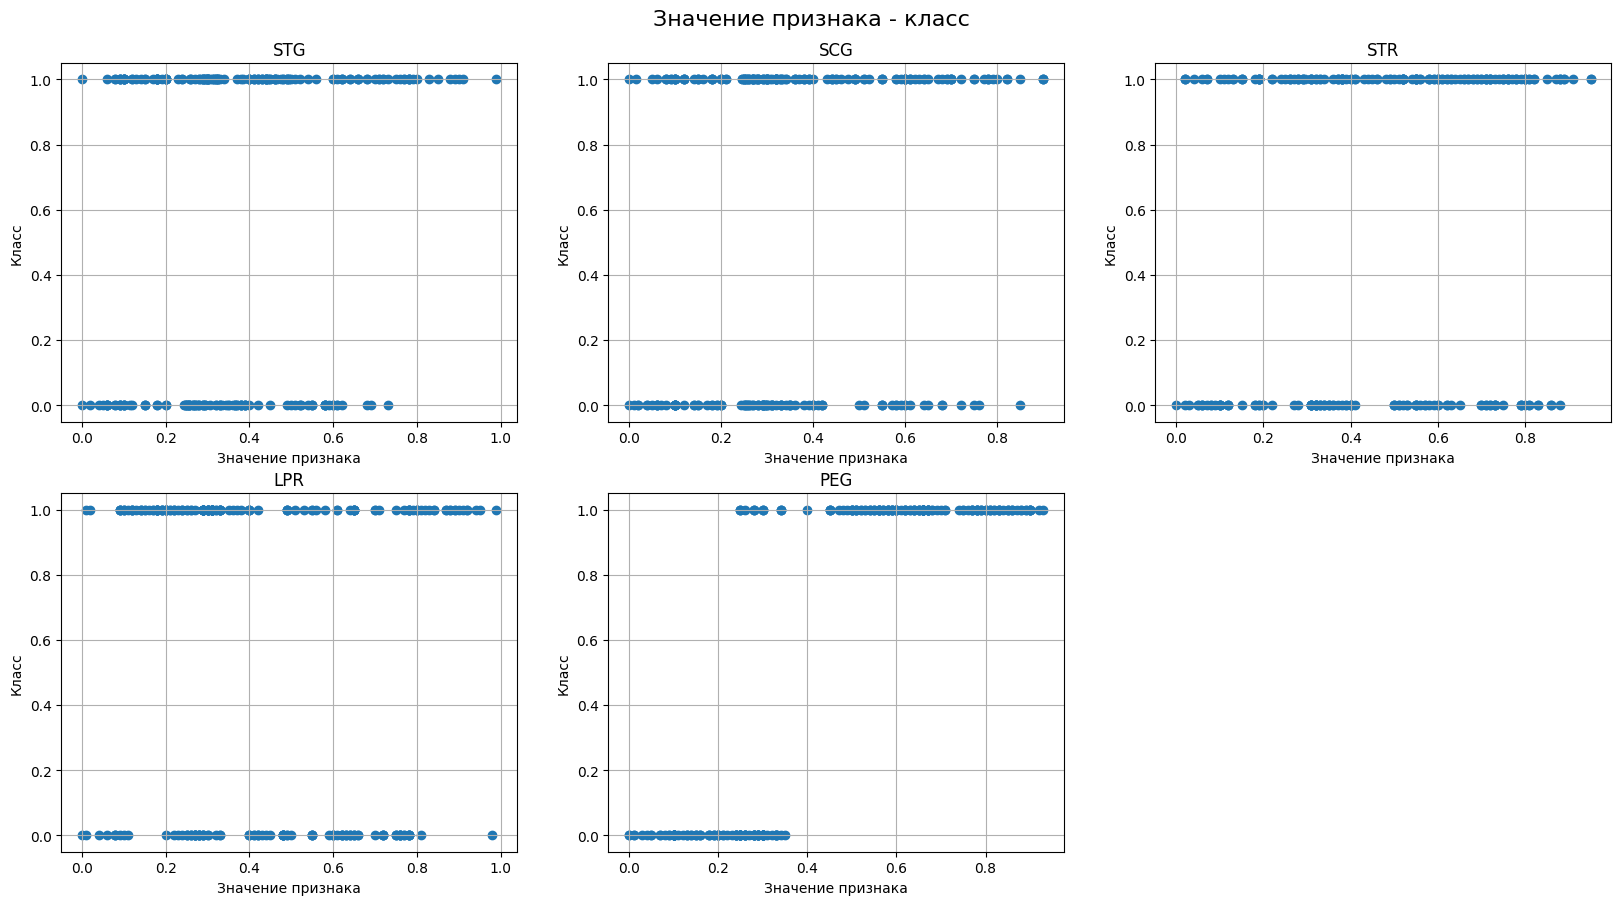

In [ ]:
plt.figure(figsize=(20, 27))
plt.suptitle('Значение признака - класс', y=0.9, fontsize=16)


num = 0
for i in data2.columns[:-1]:
    plt.subplot(5, 3, num+1)
    plt.scatter(data2[i], data2.UNS)
    plt.title(i)
    plt.xlabel('Значение признака')
    plt.ylabel('Класс')
    plt.grid()
    num += 1

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
# !wget https://archive.ics.uci.edu/static/public/73/mushroom.zip
# !unzip mushroom.zip

--2024-05-27 20:47:47--  https://archive.ics.uci.edu/static/public/73/mushroom.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘mushroom.zip.4’

mushroom.zip.4          [  <=>               ] 138.01K   356KB/s    in 0.4s    

2024-05-27 20:47:48 (356 KB/s) - ‘mushroom.zip.4’ saved [141318]

Archive:  mushroom.zip
replace Index? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
mushrooms = pd.read_csv('/content/agaricus-lepiota.data')

from sklearn.preprocessing import LabelEncoder
for col_name in mushrooms.columns:
    le = LabelEncoder()
    mushrooms.loc[:, col_name] = le.fit_transform(mushrooms.loc[:, col_name])


target = mushrooms.p
features = mushrooms.drop(columns='p')
x_train, x_test, y_train, y_test = train_test_split(features.values, target.values,
                                                    test_size=0.3, random_state=42)

feature_types = ['categorical' for x in x_train]
tree = DecisionTree(feature_types)
# my_tree.fit(x_train, y_train)
# # y_pred = my_tree.predict(x_test)
# # print('test accuracy =', np.sum(y_pred == y_test) / np.size(y_test))
# # y_pred = my_tree.predict(x_train)
# # print('train accuracy =', np.sum(y_pred == y_train) / np.size(y_train))
# # print('depth =', my_tree.depth)

Класс ошибается даже в фите, веротяней всего где-то узкий случай не рассмотрен. Так и не смогла найти ошибку, то рекурсия, то еще что-то, даже грустно как-то, прошу прощения((
  
---




<img src = 'https://cdn.fishki.net/upload/post/201502/08/1420086/pidrila-ebanaya-kotik_13326826_orig_.jpeg' width = 400>

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

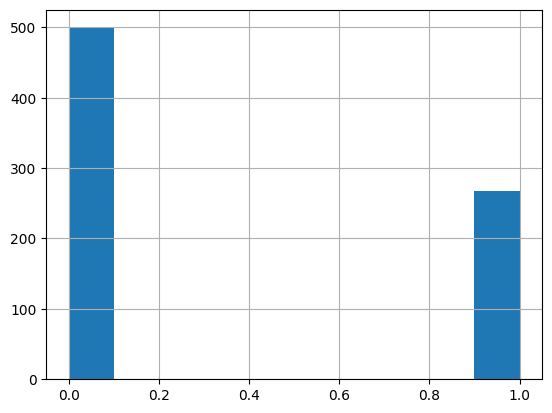

In [ ]:
data['Outcome'].hist()
plt.show()

In [ ]:
data['Outcome'].value_counts(normalize=True)

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer
X, y = data[data.columns[:-1]], data.Outcome

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
depth_values = [2, 4, 6, 8, 10] # рандомные значения
samples_leaf_values = [2, 3, 4, 5, 6]
mydict = dict() # сюда будем заносить пары параметров и значение f1 score

for i in depth_values:
  for j in samples_leaf_values:
    clf = DecisionTreeClassifier(max_depth = i, min_samples_leaf = j, random_state = 42)
    clf.fit(X_train_train, y_train_train)
    y_pred_val = clf.predict(X_val)
    mydict[(i, j)] = f1_score(y_val, y_pred_val)

In [ ]:
best_params = max(mydict, key=mydict.get) # из словаря вытаскиваем максимальный f1 score
print(f'Лучшая пара глубина - кол-во объектов в листе: {best_params}, \nf1 score = {mydict[best_params]}')

Лучшая пара глубина - кол-во объектов в листе: (6, 3), 
f1 score = 0.6666666666666666


Теперь обучаем на полном трейне, передаем подобранные на предыдущем шаге гиперпараметры best_params = (6, 3)


---



In [ ]:
best_model = DecisionTreeClassifier(max_depth=best_params[0], min_samples_leaf = best_params[1], random_state = 42)

best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

print(classification_report(y_test, y_test_pred))
print(f'Roc-auc score max_f1: {roc_auc_score(y_test, y_test_pred)}') #

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       151
           1       0.57      0.65      0.61        80

    accuracy                           0.71       231
   macro avg       0.69      0.70      0.69       231
weighted avg       0.72      0.71      0.71       231

Roc-auc score max_f1: 0.6958609271523178


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(random_state = 42, n_estimators=50)
bag.fit(X_train, y_train)

y_test_pred_bag = bag.predict(X_test)

In [ ]:
print(classification_report(y_test, y_test_pred_bag))
print(f'Roc-auc score bagging: {roc_auc_score(y_test, y_test_pred_bag)}')

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       151
           1       0.63      0.66      0.65        80

    accuracy                           0.75       231
   macro avg       0.72      0.73      0.73       231
weighted avg       0.75      0.75      0.75       231

Roc-auc score bagging: 0.7286009933774835


Композиция из 50 деревьев улучшила метрику Roc-auc: усреднение результатов 50 моделей повышает точность работы композиции в сравнениии с отдельными деревьями в бэггинге. Классификация по голосованию большинства пока что дает лучший прогноз.



---



**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
param_grid = {'max_depth': [2, 4, 6, 8, 9],
              'min_samples_split': [2, 3, 4, 6, 8]}


rf = RandomForestClassifier(n_estimators=50, random_state = 42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train) # обучить на полном трейне

best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [ ]:
print(f'Лучшие значение CV: {best_params}, \nmax f1 score CV = {best_score}')

Лучшие значение CV: {'max_depth': 8, 'min_samples_split': 3}, 
max f1 score CV = 0.6483452380952381


Обучаем на трейне, замеряем качество для RF


---



In [ ]:
best_model_rf = RandomForestClassifier(n_estimators=50, **best_params, random_state=42)
best_model_rf.fit(X_train, y_train)
y_test_pred_rf = best_model_rf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_test_pred_rf))
print(f'Roc-auc score RandomForest: {roc_auc_score(y_test, y_test_pred_rf)}')

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       151
           1       0.61      0.66      0.63        80

    accuracy                           0.74       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.74      0.74       231

Roc-auc score RandomForest: 0.7186672185430463




---

Сравнив Roc-auc у наших моделей, лучшей оказалась композиция из 50 деревьев, обученных на подвыборках. В общем, бэггинг в топе. Ниже в табличке результаты по трем моделям.

А почему случайный лес не оказался лучше?


---




In [ ]:
results = pd.DataFrame({"Model": ['Lonely tree', "Bagging", "Run, Forest!"],
                       'Roc-auc': [roc_auc_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_pred_bag), roc_auc_score(y_test, y_test_pred_rf)]})
results.round(3)

,Model,Roc-auc
0,Lonely tree,0.696
1,Bagging,0.729
2,"Run, Forest!",0.719


Посмотрим на точечные гистограммы признак - класс. В большинстве случаев на глаз трудно выявить очевидные взаимосвязи между таргетом и каким-то признаком: например график SkinThickness, Insulin, BloodPressure, Pregnancies, будто бы ни о чем не говорят вообще (опять же только визуально, надо проверять важность признаков), практически одинаковое скопление точек как на 0, так и на 1 классах таргета в одних и тех же местах - признаки кажутся неинформативными.

Случайный лес - комбо из бэггинга и метода случайных подпространств (те махинации с отбором признаков), можно предположить, что переодически важные переменные не отбираются и модель обучается на не сильно репрезентативных признаках, поэтому качество может быть хуже, чем у бэггинга, где обучаемся на подвыборках, но используем все колонки.

---




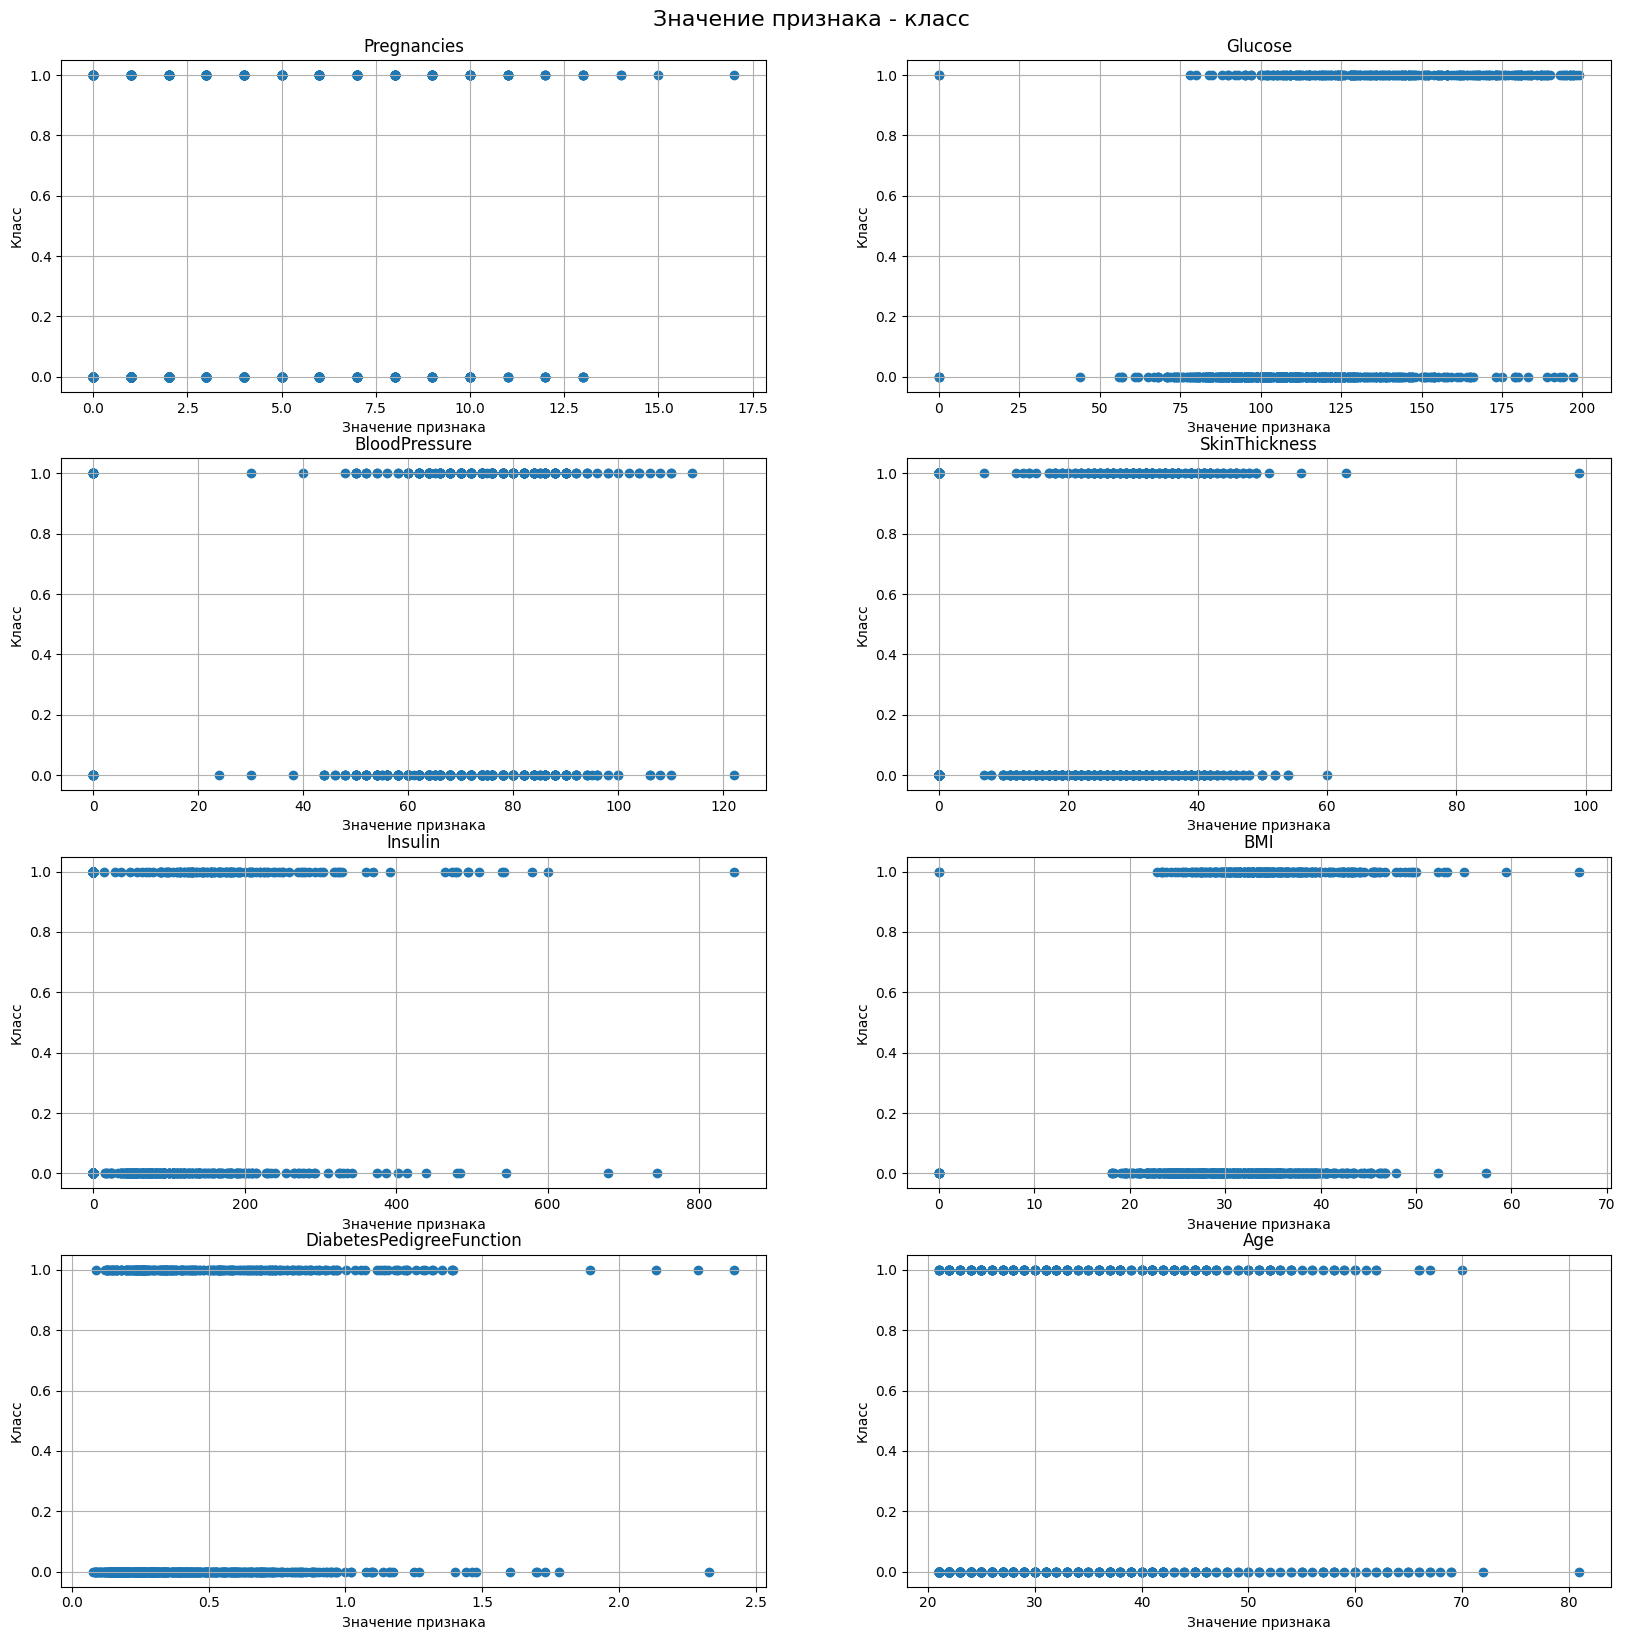

In [ ]:
plt.figure(figsize=(20, 25))
plt.suptitle('Значение признака - класс', y=0.9, fontsize=16)

num = 0
for i in data.columns[:-1]:
    plt.subplot(5, 2, num+1)
    plt.scatter(data[i], data.Outcome)
    plt.title(i)
    plt.xlabel('Значение признака')
    plt.ylabel('Класс')
    plt.grid()
    num += 1

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [ ]:
roc_auc_scores = list() # здесь будут жить наша большая семья рок ауков
for n in range(10,101,10):
  rf_rf = RandomForestClassifier(n_estimators=n, random_state=42)
  rf_rf.fit(X_train, y_train)
  y_pred_rf =rf_rf.predict_proba(X_test)[:, 1]
  roc_auc_scores.append(roc_auc_score(y_test, y_pred_rf))

Для построения ROC-кривой нам нужны истинные метки классов и предсказанные вероятности, поэтому используется метод predict_proba.



---



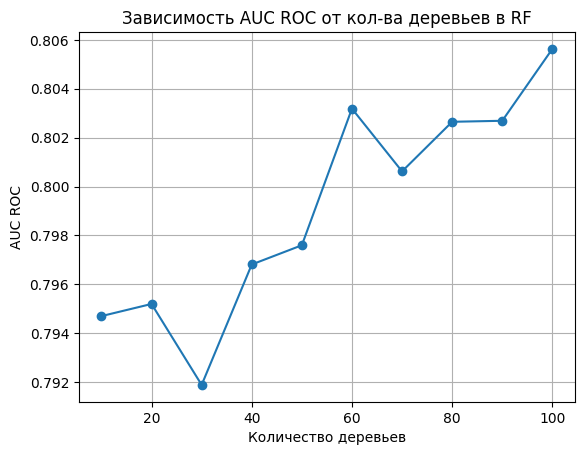

In [ ]:
plt.plot(np.arange(10,101,10), roc_auc_scores, marker='o')
plt.title('Зависимость AUC ROC от кол-ва деревьев в RF')
plt.ylabel('AUC ROC')
plt.xlabel('Количество деревьев')
plt.grid()

Увеличение числа деревьев позволяет улучшить обобщающую способность модели, благодаря усреденению ответов. Случайный лес не переобучается с ростом количества базовых моделей, поэтому как Соколов говорил "берем N побольше и оно дальше само". После какого то значения ошибка будет сидеть на минимуме плюс минус, и дальнейшее добавление новых моделей не приведет к улучшению композиции.


Площадь под Рок кривой растет из-за усреднения ответов и уменьшения дисперсии предсказаний, мы приближаемся к "идеальной" стабильной версии модели, в общем качество во всех пониманиях растет => площадь тоже растет.



---



**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [ ]:
kek = best_model_rf.feature_importances_
index = np.argsort(kek)

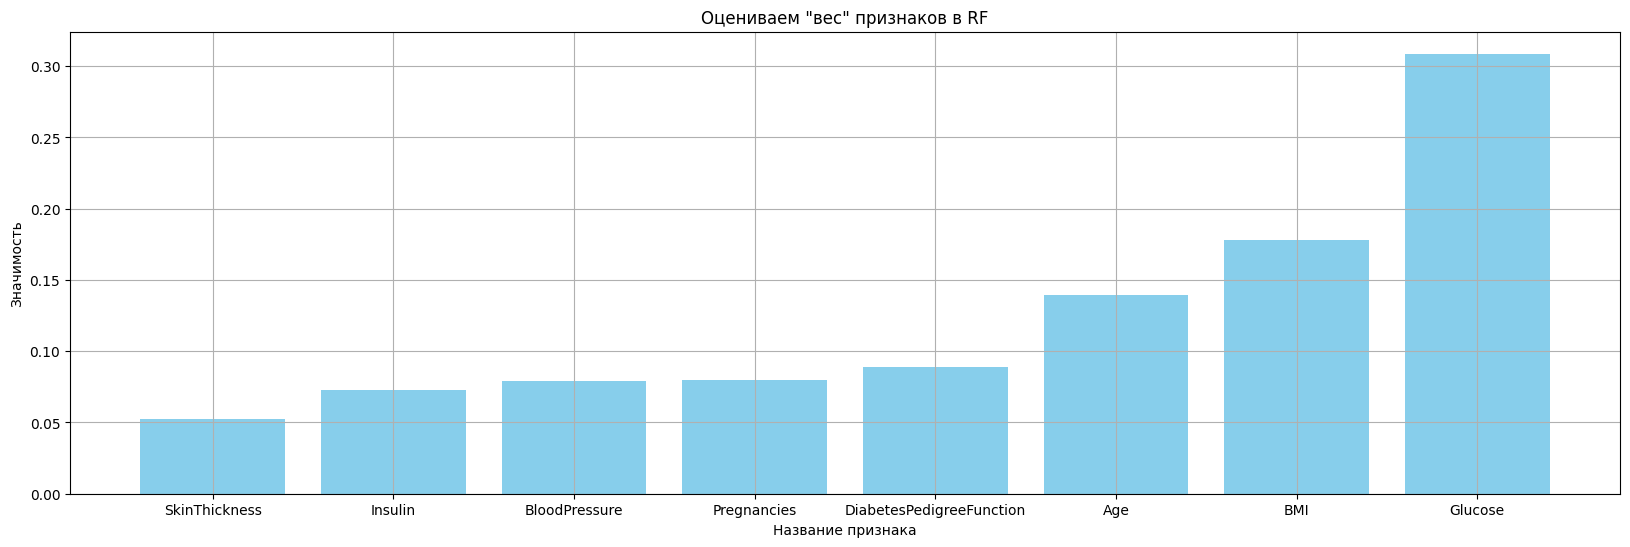

In [ ]:
plt.figure(figsize=(20, 6))
plt.bar(X_train.columns[index], kek[index], color='skyblue')

plt.xlabel('Название признака')
plt.ylabel('Значимость')
plt.title('Оцениваем "вес" признаков в RF')
plt.grid()

Топ 3 по важности: уровень глюкозы, индекс массы тела BMI и возраст. Так же видим много не сильно значимых признаков, точнее по одиночке эти признаки малоинформативны, однако от комбинаций из нескольких штук положительно растет шанс заполучить болезнь.

Случайный лес поэтому и так себе справлялся, он мог главные признаки не рассматривать (уровень глюкозы), а смотреть только на товарищей в левой части графика, базовые модели из них получатся так себе, следовательно композиция из них будет такая же.

---


А это я просто смотрела как бы логрег справился с задачей классификации диабета только по возрасту. Полнота и точность страдают, надо бы логрег обучить на все признаки

In [ ]:
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions

              precision    recall  f1-score   support

           0       0.66      0.86      0.75       151
           1       0.38      0.16      0.23        80

    accuracy                           0.62       231
   macro avg       0.52      0.51      0.49       231
weighted avg       0.56      0.62      0.57       231



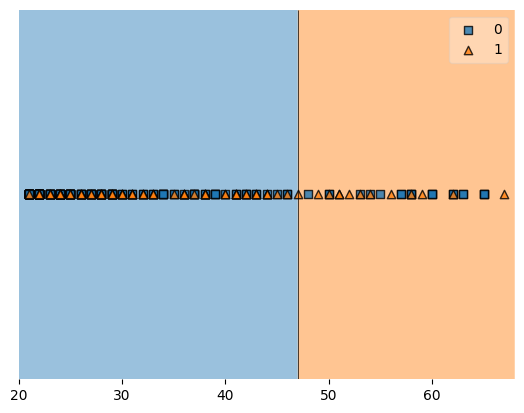

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train.Age.values.reshape(-1,1), y_train)


X_test_age = X_test.Age.values.reshape(-1,1)
y_pred_lr = lr.predict(X_test_age)

plot_decision_regions(X_test_age, y_test.values, lr);
print(classification_report(y_test, y_pred_lr))

Любое из наших деревьев справилось бы лучше


---



In [ ]:
lr = LogisticRegression(random_state=42, max_iter=200)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       151
           1       0.62      0.62      0.62        80

    accuracy                           0.74       231
   macro avg       0.71      0.71      0.71       231
weighted avg       0.74      0.74      0.74       231

